In [4]:
# import matplotlib, sys,  os
# os.environ['OPENBLAS_NUM_THREADS'] = '1'
# os.environ['OMP_NUM_THREADS'] = '1'
# os.environ['MKL_NUM_THREADS'] = '1'
# os.environ['NUMEXPR_NUM_THREADS'] = '1'
# os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
# sys.path.append("./mylib/")
# sys.path.append("../../Env/")

# import numpy as np
# import matplotlib.pyplot as plt

# np.seterr(all="ignore")
# from threeML import *
# from WCDA_hal import HAL, HealpixConeROI, HealpixMapROI
# import traceback
# silence_warnings()
# import warnings
# warnings.simplefilter("ignore")
# silence_warnings()
# from threeML import silence_progress_bars, activate_progress_bars, toggle_progress_bars
# from threeML.utils.progress_bar import trange

# from astropy.io import fits
# from astropy.wcs import WCS
# from astropy.coordinates import SkyCoord
# from astropy import units as u
# # from astropy.visualization import astropy_mpl_style, imshAow_norm
# from astropy.coordinates import Angle

# import healpy as hp

# from tqdm import tqdm

# # from mylib import *
# import mylib as my
# from importlib import reload

import sys
sys.path.append('/data/home/cwy/Science/.mylib/GAMERA')
import gappa as ga

ImportError: dynamic module does not define module export function (PyInit__gappa)

In [6]:
%matplotlib inline
region_name="GRB221009A"
if not os.path.exists(f'../res/{region_name}/'):
    os.system(f'mkdir ../res/{region_name}/')

# GRB221009A = my.lc("../../data/lc_data/GRB221009A/GRBlcunbin.root", ebin=11, funcfile="../../data/lc_data/GRB221009A/func.root") #funcfile="../../data/lc_data/GRB221009A/bkg.npy"
GRB221009A = my.lc("/data/home/cwy/Science/3MLWCDA/data/lc_data/GRB221009A/GRB221009A_2psfcut_wz_nkg.root", ebin=11, bkgfile="/data/home/cwy/Science/3MLWCDA/data/lc_data/GRB221009A/GRB221009A_2psfcut_wz_nkg_bkg.root")

# GRB221009A = my.lc("/data/home/cwy/Science/3MLWCDA/data/lc_data/GRB221009A/GRB221009A_ihep_2psfcut_unbin_haozhou.root", ebin=15, bkgfile="/data/home/cwy/Science/3MLWCDA/data/lc_data/GRB221009A/GRB221009A_ihep_2psfcut_unbin_haozhou_bkg.root")
# GRB221009A = my.lc("/data/home/cwy/Science/3MLWCDA/data/lc_data/GRB221009A/GRB221009A_ihep_3psfcut_unbin_haozhou.root", ebin=15, bkgfile="/data/home/cwy/Science/3MLWCDA/data/lc_data/GRB221009A/GRB221009A_ihep_3psfcut_unbin_haozhou_bkg.root")

GRB221009A_trig = my.lc("../../data/lc_data/GRB221009A/1009_nf_dt.root", tname="h;1", bkgfile="../../data/lc_data/GRB221009A/1008_nf_dt.root", bkgscale=2)


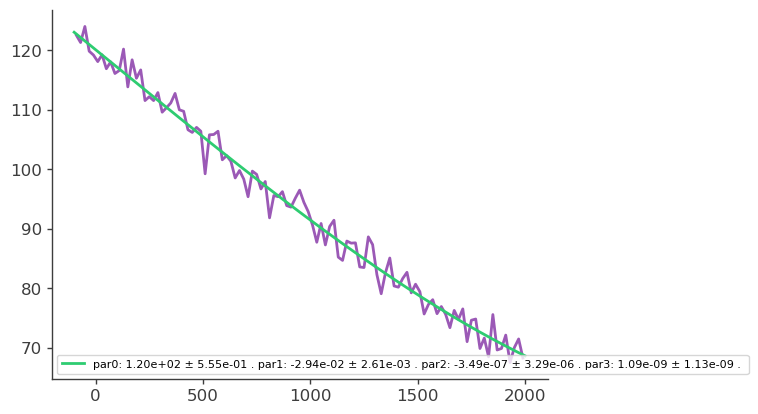

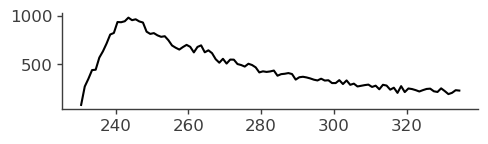

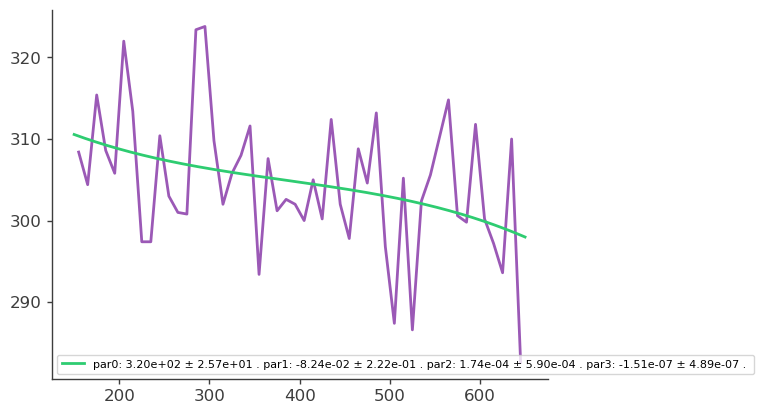

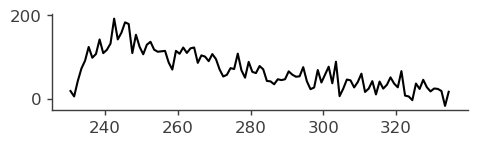

100%|██████████| 700/700 [00:00<00:00, 31702.29it/s]


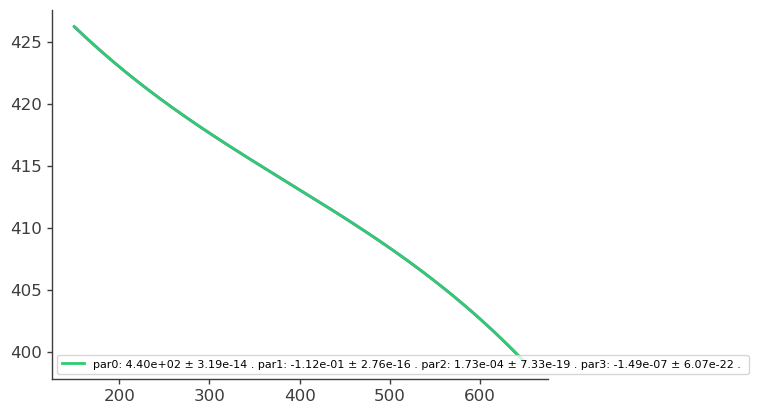

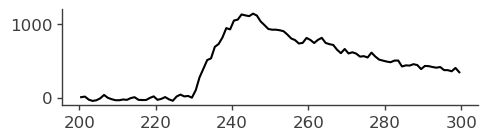

In [7]:
bin_t = 1
rebins = int(10000*bin_t)
GRB221009A.rebin(rebins)
GRB221009A.fitbkg(my.poly, -100, 2000, p0=[2, 2, 20, 2], plot=True, rebin=int(20/bin_t))
GRB221009A.drawlc() #drawbkg=True

GRB221009A_trig.rebin(rebins)
GRB221009A_trig.fitbkg(my.poly, 150, 650, p0=[2, 2, 20, 2], plot=True, rebin=int(10/bin_t))
GRB221009A_trig.drawlc()

GRB221009Aall = GRB221009A + GRB221009A_trig
GRB221009Aall.fitbkg(my.poly, 150, 650, p0=[2, 2, 20, 2], plot=True)
GRB221009Aall.drawlc(200,300)

(226.0, 300.0)

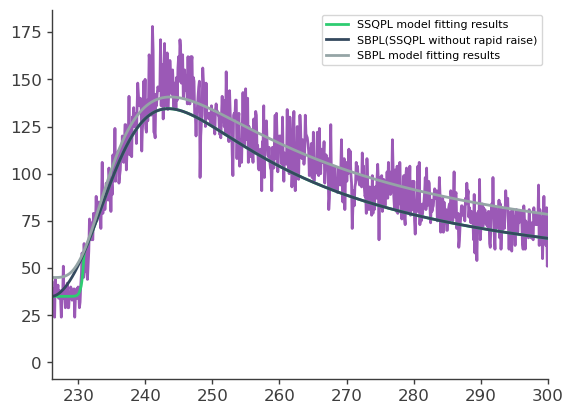

In [33]:
datas = GRB221009A.getdatafram(subbkg=False)
xx = np.linspace(200, 700, 10000)
                            #  F0,  tb,    o1,   a1,    a2, t0,  o2,   tB,      a3,  tb0,   a0
# plt.plot(xx,fSSQPL(xx-226, [240, 13.72, 0.71, 2.30, -1.14, 0, 4.49, 666.64, -2.59, 4.96, 11.21])+45)
# plt.plot(xx,SBPL(xx-226, [240, 13.72, 0.71, 2.30, -1.14, 0, 4.49, 666.64, -2.59, 4.96, 11.21])+45)
plt.plot(datas["x"], datas["y"])
plt.plot(xx,my.fSSQPL(xx-226, [185, 14.9, 1.07, 1.82, -1.115, 0, 7.4, 670, -2.21, 4.85, 14.9])+35, label="SSQPL model fitting results")
plt.plot(xx,my.fSBPL(xx-226, [185, 14.9, 1.07, 1.82, -1.115, 0, 7.4, 670, -2.21, 4.85, 14.9])+35, label="SBPL(SSQPL without rapid raise)")
plt.plot(xx,my.fSBPL(xx-226, [360, 9.89, 0.41, 3.81, -1.16, 0, 4.8, 678, -2.6])+45, label="SBPL model fitting results")
plt.legend()
# plt.ylim(30, 200)
plt.xlim(226,300)

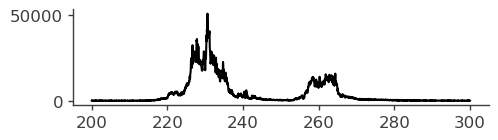

In [7]:
GRB221009A_prompr = my.lc('../../data/lc_data/GRB221009A/hebs-2.txt')
# GRB221009A_prompr.rebin(10)
GRB221009A_prompr.drawlc(200,300)

In [8]:
def powerlawlc(t, A, index, t0):
    result = A*(t-t0)**(index)
    result[t<=237]=0
    return result

promptdata = GRB221009A_prompr.getdatafram(subbkg=False)
plt.plot(promptdata["x"], promptdata["y"]-powerlawlc(promptdata["x"], 0.5e5, -1.5, 230)) #
xx = np.linspace(200,300,1000)
plt.plot(xx, powerlawlc(xx, 0.5e5, -1.5, 230))
plt.xlim(230, 250)
plt.ylim(1e2, 5000)
# plt.xscale("log")
# plt.yscale("log")

NameError: name 'GRB221009A_prompr' is not defined

In [63]:
t0=200
te=300
datafgrb = GRB221009Aall.getdatafram(subbkg=False)
# datafgrb = GRB221009A.getdatafram(subbkg=False)
datafgrb = datafgrb[(datafgrb["x"]>=t0) & (datafgrb["x"]<=te)]

22:02:24 INFO      Using Poisson log-likelihood                                                       ]8;id=805877;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/plugins/XYLike.py\XYLike.py]8;;\:]8;id=354751;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/plugins/XYLike.py#111\111]8;;\

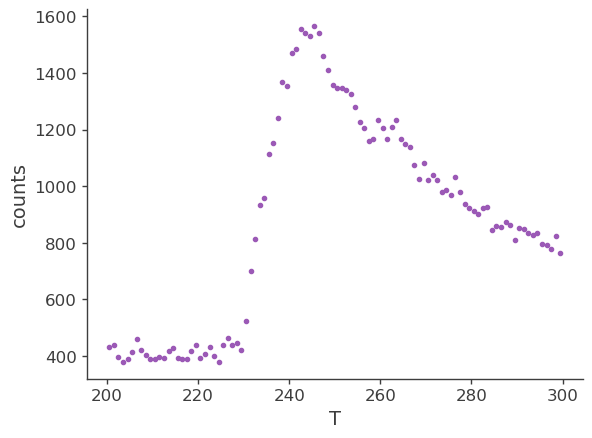

In [64]:
GRBlike = XYLike.from_dataframe("GRB221009A", datafgrb, poisson=True)
fig = GRBlike.plot(x_label="T", y_label="counts")

In [73]:
lcmodel = my.SBPL()
lcmodel.alpha1.bounds = (0,10)
lcmodel.alpha2.bounds = (-10,0)
lcmodel.F0 = 1000
lcmodel.F0.bounds = (0.1,1000000)
lcmodel.t0=226
lcmodel.t0.bounds = (220, 235)
lcmodel.t0.fix=True

lcmodelT = my.TPLM()
lcmodelT.Fc.bounds = (0,10000)
lcmodelT.alpha_c.bounds = (0,100)
lcmodelT.Tc.bounds = (-10000,10000)
lcmodelT.tc.bounds = (-1000,1000)
lcmodelT.t0=226
lcmodelT.t0.bounds = (220, 235)
lcmodelT.t0.fix=True

# linebkg = Cubic()
# linebkg.a = 113.27776
# linebkg.a.fix = True
# linebkg.b = -0.03
# linebkg.b.fix = True
# linebkg.c = 2.6e-06
# linebkg.c.fix = True
# linebkg.d = -6.18e-11
# linebkg.d.fix = True

# linebkgtri = Cubic()
# linebkgtri.a = 3.22202619e+02
# linebkgtri.a.fix = True
# linebkgtri.b = -1.06140647e-01
# linebkgtri.b.fix = True
# linebkgtri.c = 2.37156727e-04
# linebkgtri.c.fix = True
# linebkgtri.d = -2.03058449e-07
# linebkgtri.d.fix = True

# linebkg = Cubic()
# linebkg.a = GRB221009A.bkgp[0]
# linebkg.a.fix = True
# linebkg.b = GRB221009A.bkgp[1]
# linebkg.b.fix = True
# linebkg.c = GRB221009A.bkgp[2]
# linebkg.c.fix = True
# linebkg.d = GRB221009A.bkgp[3]
# linebkg.d.fix = True

linebkg = Cubic()
linebkg.a = GRB221009Aall.bkgp[0]
linebkg.a.fix = True
linebkg.b = GRB221009Aall.bkgp[1]
linebkg.b.fix = True
linebkg.c = GRB221009Aall.bkgp[2]
linebkg.c.fix = True
linebkg.d = GRB221009Aall.bkgp[3]
linebkg.d.fix = True

linebkgtri = Cubic()
linebkgtri.a = 0
linebkgtri.a.fix = True
linebkgtri.b = 0
linebkgtri.b.fix = True
linebkgtri.c = 0
linebkgtri.c.fix = True
linebkgtri.d = 0
linebkgtri.d.fix = True

linebkgeff = linebkg/linebkg(226)

lineafterglow = Cubic()
# lineafterglow.a.bounds = (0,1000)
# lineafterglow.b.bounds = (-10,10)
# lineafterglow.c.bounds = (-10,10)


gauss = Gaussian()
gauss.F=1000
gauss.F.bounds = (0,20000)
gauss.mu.bounds = (230,255)
gauss.sigma = 5
# gauss.sigma.min = 0.1
# gauss.sigma.max = 3
gauss.sigma.bounds = (0,8)

gauss2 = Gaussian()
gauss2.F.bounds = (0,20000)
gauss2.mu.bounds = (250,270)
gauss2.sigma = 2
# gauss2.sigma.min = 0.1
# gauss2.sigma.max = 3
gauss2.sigma.bounds = (0,5)

step = StepFunction()
step.value.bouds = (0,2000)
step.lower_bound.bouds=(255, 265)
step.upper_bound.bouds=(265, 275)

gauss3 = Gaussian()
gauss3.F.bounds = (0,20000)
gauss3.mu.bounds = (227,245)
gauss3.sigma = 2
# gauss3.sigma.min = 0.1
# gauss3.sigma.max = 3
gauss3.sigma.bounds = (0,4)

hebs = my.HEBS()
hebs.A.bounds = (1,2e15)
hebs.ts = 250               #!!!!!!!!!!!!!!!!!!
hebs.ts.fix = True
# hebs.ts.bounds = (226, 235)
hebs.te = 270
hebs.dt.bounds = (-1,3)
hebs.bint=bin_t/4
hebs.bint.fix = True

hebs2 = my.HEBS()
hebs2.A.bounds = (1,20000)
hebs2.ts = 229               #!!!!!!!!!!!!!!!!!!
hebs2.te = 235
hebs2.dt.bounds = (0,2)
hebs2.bint=bin_t

hebs3 = my.HEBS()
hebs3.A.bounds = (1,20000)
hebs3.ts = 239               #!!!!!!!!!!!!!!!!!!
hebs3.te = 242
hebs3.dt.bounds = (0,2)
hebs3.bint=bin_t


# lcmodelf22 = lcmodel + linebkg*bin_t + linebkgtri*bin_t + gauss + gauss3
# lcmodelf3 = lcmodel + linebkg*bin_t + linebkgtri*bin_t + gauss + gauss2
# lcmodelf32 = lcmodel + linebkg*bin_t + linebkgtri*bin_t + gauss + gauss2 + gauss3

# lcmodelf42 = lcmodel + linebkg*bin_t + linebkgtri*bin_t + gauss + hebs + gauss3
# lcmodelf5 = lcmodel + linebkg*bin_t + linebkgtri*bin_t + gauss + hebs + hebs2
# lcmodelf6 = lcmodel + linebkg*bin_t + linebkgtri*bin_t + gauss + hebs + hebs2 + hebs3
# linehebs2 = lineafterglow + linebkg*bin_t + linebkgtri*bin_t + hebs


# src22 = PointSource("GRB221009A", ra=0.0, dec=0.0, spectral_shape=lcmodelf22)
# src3 = PointSource("GRB221009A", ra=0.0, dec=0.0, spectral_shape=lcmodelf3)
# src32 = PointSource("GRB221009A", ra=0.0, dec=0.0, spectral_shape=lcmodelf32)

# src42 = PointSource("GRB221009A", ra=0.0, dec=0.0, spectral_shape=lcmodelf42)
# src5 = PointSource("GRB221009A", ra=0.0, dec=0.0, spectral_shape=lcmodelf5)
# src6 = PointSource("GRB221009A", ra=0.0, dec=0.0, spectral_shape=lcmodelf6)

# srcline2 = PointSource("GRB221009A", ra=0.0, dec=0.0, spectral_shape=linehebs2)



# model22 = Model(src22)
# model3 = Model(src3)
# model32 = Model(src32)

# lcmodelf = linebkgeff*(lcmodel + linebkg*bin_t + linebkgtri*bin_t)
# src = PointSource("GRB221009A", ra=0.0, dec=0.0, spectral_shape=lcmodelf)
# model1 = Model(src)

# lcmodelf2 = linebkgeff*(lcmodel + linebkg*bin_t + linebkgtri*bin_t + gauss)
# src2 = PointSource("GRB221009A", ra=0.0, dec=0.0, spectral_shape=lcmodelf2)
# model2 = Model(src2)

# lcmodelf4 = linebkgeff*(lcmodel + linebkg*bin_t + linebkgtri*bin_t + gauss + hebs)
# src4 = PointSource("GRB221009A", ra=0.0, dec=0.0, spectral_shape=lcmodelf4)
# model4 = Model(src4)


# lcmodelf7 = linebkgeff*(lcmodelT + linebkg*bin_t + linebkgtri*bin_t)
# src7 = PointSource("GRB221009A", ra=0.0, dec=0.0, spectral_shape=lcmodelf7)
# model7 = Model(src7)

lcmodelf8 = linebkgeff*(lcmodelT + linebkg*bin_t + linebkgtri*bin_t + gauss + hebs)
src8 = PointSource("GRB221009A", ra=0.0, dec=0.0, spectral_shape=lcmodelf8)
model8 = Model(src8)

# lcmodelf9 = linebkgeff*(lcmodelT + linebkg*bin_t + linebkgtri*bin_t + gauss)
# src9 = PointSource("GRB221009A", ra=0.0, dec=0.0, spectral_shape=lcmodelf9)
# model9 = Model(src9)

# lcmodelf10 = linebkgeff*(lcmodelT + linebkg*bin_t + linebkgtri*bin_t +hebs)
# src10 = PointSource("GRB221009A", ra=0.0, dec=0.0, spectral_shape=lcmodelf10)
# model10 = Model(src10)

# lcmodelf11 = linebkgeff*(lcmodelT + linebkg*bin_t + linebkgtri*bin_t + gauss + step)
# src11 = PointSource("GRB221009A", ra=0.0, dec=0.0, spectral_shape=lcmodelf11)
# model11 = Model(src11)
# model11


#, model9.GRB221009A.spectrum.main.composite.dt_5: np.linspace(0.1, 1.9, 5)

# model42 = Model(src42)

# modelline3 = Model(srcline2)
# model5 = Model(src5)
# model6 = Model(src6)
# model1.display(complete=True)
# model2.display(complete=True)
# model22.display(complete=True)
# model3.display(complete=True)
# model32.display(complete=True)
# model4.display(complete=True)
# model42.display(complete=True)
# model5.display(complete=True)
# model6.display(complete=True)

In [74]:
if lcmodelT.t0.fix:
    fixtxt=f"fixt0{lcmodelT.t0.value}"
else:
    fixtxt=f"freet0"

# Modelname=f"lcihep{bin_t}+TPLM{fixtxt}+linebkg"
# if not os.path.exists(f'../res/{region_name}/{Modelname}/'):
#     os.system(f'mkdir ../res/{region_name}/{Modelname}/')
# model7.save(f"../res/{region_name}/{Modelname}/Model_init.yml", overwrite=True)
# result = my.fit(region_name, Modelname, GRBlike, model7, mini="ROOT", donwtlimit=False)

# Modelname=f"lcihep{bin_t}+TPLM{fixtxt}+linebkg+hebs_250_270"
# if not os.path.exists(f'../res/{region_name}/{Modelname}/'):
#     os.system(f'mkdir ../res/{region_name}/{Modelname}/')
# model10.save(f"../res/{region_name}/{Modelname}/Model_init.yml", overwrite=True)
# result = my.fit(region_name, Modelname, GRBlike, model10, mini="ROOT", grids={model10.GRB221009A.spectrum.main.composite.dt_4: np.linspace(0.1, 1.9, 5)}, donwtlimit=False) 

# Modelname=f"lcihep{bin_t}+TPLM{fixtxt}+linebkg+gauss"
# if not os.path.exists(f'../res/{region_name}/{Modelname}/'):
#     os.system(f'mkdir ../res/{region_name}/{Modelname}/')
# model9.save(f"../res/{region_name}/{Modelname}/Model_init.yml", overwrite=True)
# result = my.fit(region_name, Modelname, GRBlike, model9, mini="ROOT", grids={model9.GRB221009A.spectrum.main.composite.mu_4: np.linspace(231, 254, 5)}, donwtlimit=False) #, model9.GRB221009A.spectrum.main.composite.dt_5: np.linspace(0.1, 1.9, 5)

Modelname=f"lcihep{bin_t}+TPLM{fixtxt}+linebkg+gauss+hebs_250_270"
if not os.path.exists(f'../res/{region_name}/{Modelname}/'):
    os.system(f'mkdir ../res/{region_name}/{Modelname}/')
model8.save(f"../res/{region_name}/{Modelname}/Model_init.yml", overwrite=True)
result = my.fit(region_name, Modelname, GRBlike, model8, mini="ROOT", grids={model8.GRB221009A.spectrum.main.composite.mu_4: np.linspace(231, 254, 3), model8.GRB221009A.spectrum.main.composite.dt_5: np.linspace(0.1, 1.9, 3)}, donwtlimit=False) 

# Modelname=f"lcihep{bin_t}+TPLM{fixtxt}+linebkg+gauss+step"
# if not os.path.exists(f'../res/{region_name}/{Modelname}/'):
#     os.system(f'mkdir ../res/{region_name}/{Modelname}/')
# model11.save(f"../res/{region_name}/{Modelname}/Model_init.yml", overwrite=True)
# result = my.fit(region_name, Modelname, GRBlike, model11, mini="ROOT", donwtlimit=False, grids={model11.GRB221009A.spectrum.main.composite.lower_bound_5: np.linspace(255, 265, 4), model11.GRB221009A.spectrum.main.composite.upper_bound_5: np.linspace(265, 275, 4)} ) #

22:38:25 INFO      set the minimizer to minuit                                             ]8;id=853812;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=577111;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1042\1042]8;;\

         INFO      set the minimizer to grid                                               ]8;id=711460;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=690684;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1042\1042]8;;\

Grid Minimization:   0%|          | 0/9 [00:00<?, ?it/s]

22:47:40 INFO                                                                               ]8;id=721692;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=892948;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#294\294]8;;\
                                                                                                                   
                  Results after global minimizer (before secondary optimization):                                  

,result,unit
parameter,,
GRB221009A.spectrum.main.composite.Fc_2,(8.327687958759055 +/- 0) x 10^2,
GRB221009A.spectrum.main.composite.alpha_c_2,1.227696069334261 +/- 0,
GRB221009A.spectrum.main.composite.Tc_2,(-1.8145350248782233 +/- 0) x 10^2,s
GRB221009A.spectrum.main.composite.tc_2,(1.3356571834629563 +/- 0) x 10,s
GRB221009A.spectrum.main.composite.F_4,(4.218182497068858 +/- 0) x 10^3,1 / (s cm2)
GRB221009A.spectrum.main.composite.mu_4,(2.4276983849755673 +/- 0) x 10^2,keV
GRB221009A.spectrum.main.composite.sigma_4,5.3942980697990155 +/- 0,keV
GRB221009A.spectrum.main.composite.A_5,(5.364925526758064 +/- 0) x 10^2,
GRB221009A.spectrum.main.composite.dt_5,1.6500144096009457 +/- 0,s


         INFO                                                                               ]8;id=243641;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=282741;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#300\300]8;;\
                  Total log-likelihood minimum: 480.386                                                            
                                                                                                                   

Best fit values:

,result,unit
parameter,,
GRB221009A.spectrum.main.composite.Fc_2,(8.3 +/- 2.0) x 10^2,
GRB221009A.spectrum.main.composite.alpha_c_2,1.23 +/- 0.10,
GRB221009A.spectrum.main.composite.Tc_2,(-1.81 +/- 0.09) x 10^2,s
GRB221009A.spectrum.main.composite.tc_2,(1.34 +/- 0.09) x 10,s
GRB221009A.spectrum.main.composite.F_4,(4.2 +/- 1.3) x 10^3,1 / (s cm2)
GRB221009A.spectrum.main.composite.mu_4,(2.428 +/- 0.005) x 10^2,keV
GRB221009A.spectrum.main.composite.sigma_4,5.4 +/- 0.7,keV
GRB221009A.spectrum.main.composite.A_5,(5.4 -1.5 +2.0) x 10^2,
GRB221009A.spectrum.main.composite.dt_5,1.65 +/- 0.06,s


Correlation matrix:

1.00,-0.86,-1.00,0.37,-0.79,0.01,-0.60,0.01,0.00
-0.86,1.00,0.89,-0.10,0.59,-0.24,0.47,-0.28,-0.00
-1.00,0.89,1.00,-0.29,0.80,-0.08,0.63,-0.05,-0.00
0.37,-0.10,-0.29,1.00,0.10,-0.71,0.30,0.04,0.00
-0.79,0.59,0.80,0.10,1.00,-0.26,0.92,0.29,-0.00
0.01,-0.24,-0.08,-0.71,-0.26,1.00,-0.35,0.09,-0.00
-0.60,0.47,0.63,0.30,0.92,-0.35,1.00,0.29,-0.00
0.01,-0.28,-0.05,0.04,0.29,0.09,0.29,1.00,0.01
0.00,-0.00,-0.00,0.00,-0.00,-0.00,-0.00,0.01,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
GRB221009A,480.38633
total,480.38633


Values of statistical measures:

,statistical measures
AIC,980.772660
BIC,1002.219191


In [156]:
if lcmodel.t0.fix:
    fixtxt=f"fixt0{lcmodel.t0.value}"
else:
    fixtxt=f"freet0"

# Modelname=f"lc{bin_t}+cubic+linebkg+hebs_250_270"
# if not os.path.exists(f'../res/{region_name}/{Modelname}/'):
#     os.system(f'mkdir ../res/{region_name}/{Modelname}/')
# modelline3.save(f"../res/{region_name}/{Modelname}/Model_init.yml", overwrite=True)
# result = my.fit(region_name, Modelname, GRBlike, modelline3, mini="ROOT", grids={modelline3.GRB221009A.spectrum.main.composite.dt_4: np.linspace(-0.9, 2.9, 10)}, donwtlimit=False)
#, model4.GRB221009A.spectrum.main.composite.ts_5: np.linspace(230, 234, 2)




# Modelname=f"lc{bin_t}+SBPL{fixtxt}+linebkg"
# if not os.path.exists(f'../res/{region_name}/{Modelname}/'):
#     os.system(f'mkdir ../res/{region_name}/{Modelname}/')
# model1.save(f"../res/{region_name}/{Modelname}/Model_init.yml", overwrite=True)
# result = my.fit(region_name, Modelname, GRBlike, model1, mini="ROOT", donwtlimit=False)

# Modelname=f"lcihep{bin_t}+SBPL{fixtxt}+linebkg"
# if not os.path.exists(f'../res/{region_name}/{Modelname}/'):
#     os.system(f'mkdir ../res/{region_name}/{Modelname}/')
# model1.save(f"../res/{region_name}/{Modelname}/Model_init.yml", overwrite=True)
# result = my.fit(region_name, Modelname, GRBlike, model1, mini="ROOT", donwtlimit=False)


# Modelname=f"lc{bin_t}+SBPL{fixtxt}+linebkg+gauss"
# if not os.path.exists(f'../res/{region_name}/{Modelname}/'):
#     os.system(f'mkdir ../res/{region_name}/{Modelname}/')
# model2.save(f"../res/{region_name}/{Modelname}/Model_init.yml", overwrite=True)
# result = my.fit(region_name, Modelname, GRBlike, model2, mini="ROOT", grids={model2.GRB221009A.spectrum.main.composite.mu_4: np.linspace(231, 254, 10), model2.GRB221009A.spectrum.main.composite.sigma_4: np.linspace(2, 6, 10)}, donwtlimit=False)

# Modelname=f"lchebs{bin_t}+SBPL{fixtxt}+linebkg+gauss"
# if not os.path.exists(f'../res/{region_name}/{Modelname}/'):
#     os.system(f'mkdir ../res/{region_name}/{Modelname}/')
# model2.save(f"../res/{region_name}/{Modelname}/Model_init.yml", overwrite=True)
# result = my.fit(region_name, Modelname, GRBlike, model2, mini="ROOT", grids={model2.GRB221009A.spectrum.main.composite.mu_4: np.linspace(231, 254, 10), model2.GRB221009A.spectrum.main.composite.sigma_4: np.linspace(2, 6, 10)}, donwtlimit=False)

# Modelname=f"lc{bin_t}+SBPL{fixtxt}+linebkg+gauss3+gauss"
# if not os.path.exists(f'../res/{region_name}/{Modelname}/'):
#     os.system(f'mkdir ../res/{region_name}/{Modelname}/')
# model22.save(f"../res/{region_name}/{Modelname}/Model_init.yml", overwrite=True)
# result = my.fit(region_name, Modelname, GRBlike, model22, mini="ROOT", grids={model22.GRB221009A.spectrum.main.composite.mu_5: np.linspace(230, 244, 10), model22.GRB221009A.spectrum.main.composite.sigma_5: np.linspace(0.5, 3, 10)}, donwtlimit=False)

# Modelname="lc1+SBPLfreet0+linebkg+2*gauss"
# if not os.path.exists(f'../res/{region_name}/{Modelname}/'):
#     os.system(f'mkdir ../res/{region_name}/{Modelname}/')
# model3.save(f"../res/{region_name}/{Modelname}/Model_init.yml", overwrite=True)
# result = my.fit(region_name, Modelname, GRBlike, model3, mini="ROOT", grids={model3.GRB221009A.spectrum.main.composite.mu_5: np.linspace(256, 269, 10), model3.GRB221009A.spectrum.main.composite.sigma_5: np.linspace(0.5, 4, 10)}, donwtlimit=False)

# Modelname=f"lc{bin_t}+SBPL{fixtxt}+linebkg+gauss3+2gauss"
# if not os.path.exists(f'../res/{region_name}/{Modelname}/'):
#     os.system(f'mkdir ../res/{region_name}/{Modelname}/')
# model32.save(f"../res/{region_name}/{Modelname}/Model_init.yml", overwrite=True)
# result = my.fit(region_name, Modelname, GRBlike, model32, mini="ROOT", grids={model32.GRB221009A.spectrum.main.composite.mu_4: np.linspace(231, 254, 10), model32.GRB221009A.spectrum.main.composite.sigma_4: np.linspace(1, 7, 10)}, donwtlimit=False)

# Modelname=f"lc{bin_t}+SBPL{fixtxt}+linebkg+gauss+hebs_229_270"
# if not os.path.exists(f'../res/{region_name}/{Modelname}/'):
#     os.system(f'mkdir ../res/{region_name}/{Modelname}/')
# model4.save(f"../res/{region_name}/{Modelname}/Model_init.yml", overwrite=True)
# result = my.fit(region_name, Modelname, GRBlike, model4, mini="ROOT", grids={model4.GRB221009A.spectrum.main.composite.mu_4: np.linspace(231, 254, 2), model4.GRB221009A.spectrum.main.composite.dt_5: np.linspace(0.1, 1.9, 2)}, donwtlimit=False)
# #, model4.GRB221009A.spectrum.main.composite.ts_5: np.linspace(230, 234, 2)

# Modelname=f"lc{bin_t}+SBPL{fixtxt}+linebkg+gauss+hebs_250_270+gauss3"
# if not os.path.exists(f'../res/{region_name}/{Modelname}/'):
#     os.system(f'mkdir ../res/{region_name}/{Modelname}/')
# model42.save(f"../res/{region_name}/{Modelname}/Model_init.yml", overwrite=True)
# result = my.fit(region_name, Modelname, GRBlike, model42, mini="ROOT", grids={model42.GRB221009A.spectrum.main.composite.mu_4: np.linspace(231, 254, 2), model42.GRB221009A.spectrum.main.composite.dt_5: np.linspace(0.1, 1.9, 2)}, donwtlimit=False)

# Modelname=f"lcihep{bin_t}+SBPL{fixtxt}+linebkg+gauss+hebs_250_270"
# if not os.path.exists(f'../res/{region_name}/{Modelname}/'):
#     os.system(f'mkdir ../res/{region_name}/{Modelname}/')
# model4.save(f"../res/{region_name}/{Modelname}/Model_init.yml", overwrite=True)
# result = my.fit(region_name, Modelname, GRBlike, model4, mini="ROOT", grids={model4.GRB221009A.spectrum.main.composite.mu_4: np.linspace(231, 254, 5), model4.GRB221009A.spectrum.main.composite.dt_5: np.linspace(0.1, 1.9, 5)}, donwtlimit=False) #

# Modelname=f"lcihep{bin_t}+TPLM{fixtxt}+linebkg+gauss+hebs_250_270"
# if not os.path.exists(f'../res/{region_name}/{Modelname}/'):
#     os.system(f'mkdir ../res/{region_name}/{Modelname}/')
# model9.save(f"../res/{region_name}/{Modelname}/Model_init.yml", overwrite=True)
# result = my.fit(region_name, Modelname, GRBlike, model9, mini="ROOT", grids={model9.GRB221009A.spectrum.main.composite.mu_4: np.linspace(231, 254, 5)}, donwtlimit=False) #, model9.GRB221009A.spectrum.main.composite.dt_5: np.linspace(0.1, 1.9, 5)

# Modelname=f"lcihep{bin_t}+TPLM{fixtxt}+linebkg+gauss+hebs_250_270"
# if not os.path.exists(f'../res/{region_name}/{Modelname}/'):
#     os.system(f'mkdir ../res/{region_name}/{Modelname}/')
# model9.save(f"../res/{region_name}/{Modelname}/Model_init.yml", overwrite=True)
# result = my.fit(region_name, Modelname, GRBlike, model9, mini="ROOT", grids={model9.GRB221009A.spectrum.main.composite.mu_4: np.linspace(231, 254, 5)}, donwtlimit=False) #, model9.GRB221009A.spectrum.main.composite.dt_5: np.linspace(0.1, 1.9, 5)


# Modelname="lc0.1+SBPL+linebkg+gauss+hebs_250_270+hebs_239_242"
# if not os.path.exists(f'../res/{region_name}/{Modelname}/'):
#     os.system(f'mkdir ../res/{region_name}/{Modelname}/')
# model5.save(f"../res/{region_name}/{Modelname}/Model_init.yml", overwrite=True)
# result = my.fit(region_name, Modelname, GRBlike, model5, mini="ROOT", grids={model5.GRB221009A.spectrum.main.composite.mu_3: np.linspace(230, 290, 5)}, donwtlimit=False) #, model5.GRB221009A.spectrum.main.composite.dt_4: np.linspace(-2, 2, 5)

# Modelname="lc0.1+SBPL+linebkg+gauss+hebs_250_270+hebs_229_235"
# if not os.path.exists(f'../res/{region_name}/{Modelname}/'):
#     os.system(f'mkdir ../res/{region_name}/{Modelname}/')
# model5.save(f"../res/{region_name}/{Modelname}/Model_init.yml", overwrite=True)
# result = my.fit(region_name, Modelname, GRBlike, model5, mini="ROOT", grids={model5.GRB221009A.spectrum.main.composite.mu_3: np.linspace(230, 290, 5)}, donwtlimit=False) # model5.GRB221009A.spectrum.main.composite.dt_4: np.linspace(-2, 2, 5), model5.GRB221009A.spectrum.main.composite.dt_5: np.linspace(-2, 2, 5)


# Modelname="lc0.1+SBPL+linebkg+gauss+hebs_250_270+hebs_229_235+hebs_239_242"
# if not os.path.exists(f'../res/{region_name}/{Modelname}/'):
#     os.system(f'mkdir ../res/{region_name}/{Modelname}/')
# model6.save(f"../res/{region_name}/{Modelname}/Model_init.yml", overwrite=True)
# result = my.fit(region_name, Modelname, GRBlike, model6, mini="ROOT", donwtlimit=False) # model5.GRB221009A.spectrum.main.composite.dt_4: np.linspace(-2, 2, 5), model5.GRB221009A.spectrum.main.composite.dt_5: np.linspace(-2, 2, 5) , grids={model6.GRB221009A.spectrum.main.composite.mu_3: np.linspace(228, 254, 1)}

12:36:04 INFO      set the minimizer to minuit                                             ]8;id=911010;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=315949;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1042\1042]8;;\

         INFO      set the minimizer to grid                                               ]8;id=207802;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=143882;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1042\1042]8;;\

Grid Minimization:   0%|          | 0/5 [00:00<?, ?it/s]

12:36:05 INFO                                                                               ]8;id=754764;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=17762;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#294\294]8;;\
                                                                                                                   
                  Results after global minimizer (before secondary optimization):                                  

,result,unit
parameter,,
GRB221009A.spectrum.main.composite.Fc_2,(6.064491135765853 +/- 0) x 10^2,
GRB221009A.spectrum.main.composite.alpha_c_2,1.2691912054971137 +/- 0,
GRB221009A.spectrum.main.composite.Tc_2,(-1.7514337838173197 +/- 0) x 10^2,s
GRB221009A.spectrum.main.composite.tc_2,7.478773453669874 +/- 0,s
GRB221009A.spectrum.main.composite.t0_2,(2.2793537942470006 +/- 0) x 10^2,s
GRB221009A.spectrum.main.composite.F_4,(2.392946811425256 +/- 0) x 10^3,1 / (s cm2)
GRB221009A.spectrum.main.composite.mu_4,(2.4376735028560206 +/- 0) x 10^2,keV
GRB221009A.spectrum.main.composite.sigma_4,3.980000082855341 +/- 0,keV


         INFO                                                                               ]8;id=455367;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=241888;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#300\300]8;;\
                  Total log-likelihood minimum: 937.822                                                            
                                                                                                                   

Best fit values:

,result,unit
parameter,,
GRB221009A.spectrum.main.composite.Fc_2,(6.1 +/- 0.5) x 10^2,
GRB221009A.spectrum.main.composite.alpha_c_2,1.269 +/- 0.025,
GRB221009A.spectrum.main.composite.Tc_2,(-1.751 +/- 0.030) x 10^2,s
GRB221009A.spectrum.main.composite.tc_2,7.5 +/- 0.8,s
GRB221009A.spectrum.main.composite.t0_2,(2.2794 +/- 0.0032) x 10^2,s
GRB221009A.spectrum.main.composite.F_4,(2.4 +/- 0.4) x 10^3,1 / (s cm2)
GRB221009A.spectrum.main.composite.mu_4,(2.438 +/- 0.004) x 10^2,keV
GRB221009A.spectrum.main.composite.sigma_4,4.0 +/- 0.5,keV


Correlation matrix:

1.00,-0.30,-0.93,0.73,-0.59,-0.42,-0.34,-0.27
-0.30,1.00,0.57,0.30,-0.38,0.40,-0.22,0.33
-0.93,0.57,1.00,-0.43,0.26,0.60,0.18,0.43
0.73,0.30,-0.43,1.00,-0.94,0.16,-0.53,0.22
-0.59,-0.38,0.26,-0.94,1.00,-0.24,0.45,-0.25
-0.42,0.40,0.60,0.16,-0.24,1.00,-0.10,0.84
-0.34,-0.22,0.18,-0.53,0.45,-0.10,1.00,-0.10
-0.27,0.33,0.43,0.22,-0.25,0.84,-0.10,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
GRB221009A,937.821664
total,937.821664


Values of statistical measures:

,statistical measures
AIC,1892.397255
BIC,1918.029868


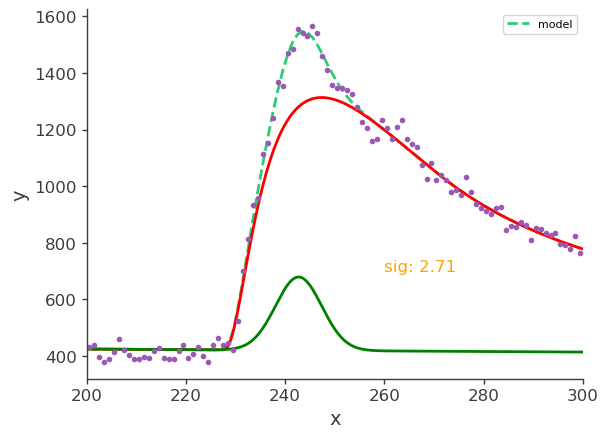

In [ ]:
%matplotlib inline
GRBlike.plot()

xx = np.arange(t0,te,0.001)

yy = (linebkgeff*(linebkg*bin_t+linebkgtri*bin_t+lcmodelT))(xx)
plt.plot(xx,yy, color="red")

yy = (linebkgeff*(linebkg*bin_t+linebkgtri*bin_t+gauss))(xx)
plt.plot(xx,yy, color="green")

# yy = (linebkgeff*(linebkg*bin_t+linebkgtri*bin_t+hebs))(xx)
# plt.plot(xx,yy, color="orange")

# yy = (linebkgeff*(linebkg*bin_t+linebkgtri*bin_t+step))(xx)
# plt.plot(xx,yy, color="orange")

# yy = (linebkgeff*(linebkg*bin_t+linebkgtri*bin_t+lcmodelT))(xx)
# plt.plot(xx,yy, color="red")

# yy = (linebkgeff*(linebkg*bin_t+linebkgtri*bin_t+lcmodel))(xx)
# plt.plot(xx,yy, color="red")

# yy = linehebs3(xx)
# plt.plot(xx,yy, color="red")

# yy0 = (linebkg*bin_t+linebkgtri*bin_t+gauss3)(xx)
# plt.plot(xx,yy0, color="blue")

# yy2 = (linebkgeff*(linebkg*bin_t+linebkgtri*bin_t+gauss))(xx)
# plt.plot(xx,yy2, color="black")

# yy3 = (linebkg*bin_t+linebkgtri*bin_t+gauss2)(xx)
# plt.plot(xx,yy3, color="green")

# yy4 = (linebkgeff*(linebkg*bin_t+linebkgtri*bin_t+hebs))(xx)
# plt.plot(xx,yy4, color="orange")

# yy5 = (linebkg*bin_t+hebs2)(xx)
# plt.plot(xx,yy5, color="orange")

# yy6 = (linebkg*bin_t+hebs3)(xx)
# plt.plot(xx,yy6, color="orange")

plt.xlim(200,300)
plt.annotate(f"sig: {my.calculate_significance(2, 485.348089, 479.661317):.2f}", (260, 700), color="orange")

plt.savefig(f"../res/{region_name}/{Modelname}/lc.png", dpi=300)
plt.savefig(f"../res/{region_name}/{Modelname}/lc.pdf", dpi=300)

plt.show()

In [43]:
my.calculate_significance(2, 284.780755, 269.037812)

5.129156893015179